<a href="https://colab.research.google.com/github/niteshg97/GPU-Based-Machine-Learning-for-Higgs-Boson-Process-Classification/blob/main/Analysis_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install RAPIDS - This might take a few minutes
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

# Install other necessary libraries
!pip install xgboost matplotlib seaborn

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 16.61 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 180 packages in 10.62s
Prepared 41 packages in 42.47s
Uninstalled 31 packages in 1.14s
Installed 41 packages in 411ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + 

In [ ]:
# Download the dataset file directly into Colab
!wget https://archive.ics.uci.edu/static/public/280/higgs.zip -O higgs.zip


--2025-10-21 16:46:06--  https://archive.ics.uci.edu/static/public/280/higgs.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘higgs.zip’

higgs.zip               [           <=>      ]   2.62G  10.0MB/s    in 6m 2s   

2025-10-21 16:52:08 (7.42 MB/s) - ‘higgs.zip’ saved [2816865137]



In [ ]:

# Check if the file is there
!ls -lh

total 13G
drwx------ 5 root root 4.0K Oct 21 16:42 drive
-rw-r--r-- 1 root root 7.5G Oct 21 17:07 HIGGS.csv
-rwx------ 1 root root 2.7G May 22  2023 HIGGS.csv.gz
-rw-r--r-- 1 root root 2.7G Oct 21 16:52 higgs.zip
drwxr-xr-x 6 root root 4.0K Oct 21 16:43 rapidsai-csp-utils
drwxr-xr-x 1 root root 4.0K Oct 17 22:29 sample_data


In [ ]:
!unzip higgs.zip

Archive:  higgs.zip
replace HIGGS.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HIGGS.csv.gz            


In [ ]:
import cudf
import gzip
import shutil

# Define the file paths
gzipped_file_path = 'HIGGS.csv.gz'
uncompressed_file_path = 'HIGGS.csv'

# Unzip the file
with gzip.open(gzipped_file_path, 'rb') as f_in:
    with open(uncompressed_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Load the massive dataset using cuDF
# This will be significantly faster than pandas
# The CSV has no header, so we'll name the columns manually
# Column names are based on the dataset documentation
col_names = [
    'label', 'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude',
    'missing_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_btag',
    'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_btag', 'jet_3_pt', 'jet_3_eta',
    'jet_3_phi', 'jet_3_btag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_btag',
    'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_tw'
]

higgs_df = cudf.read_csv(uncompressed_file_path, header=None, names=col_names)

print("Dataset loaded successfully!")
print("Shape of the dataset:", higgs_df.shape)

Dataset loaded successfully!
Shape of the dataset: (11000000, 29)


# Analysis and Preprocessing

* This notebook contains the data analysis and preprocessing applied to the dataset used in the implementation of a GPU-based machine learning technique for discriminating between a signal process that produces Higgs bosons and a background process that does not.

In [ ]:
import cudf
import pandas as pd
import cupy as cp
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline

# 1.  Exploratory Data Analysis (EDA)
* For this study, the UCI Higgs dataset will be used for training and testing. This dataset aims to aid in solving the classification problem that distinguishes between a signal process responsible for producing Higgs bosons and a background process that does not. The objective of the dataset is to explore the use of deep learning methods to automate the feature engineering process currently performed manually by physicists.

The dataset is comprised of 11 million instances generated via Monte Carlo simulations. Each instance is represented by 29 features.

In [ ]:
df = cudf.read_csv('./HIGGS.csv')
print('data shape:',df.shape)

data shape: (10999999, 29)


In [ ]:
columns = ['process', 'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
df.columns = columns

In [ ]:
'''
This copy of the dataset is saved in pandas only to be used with plotting libraries such as matplotlib and seaborn.
This will facilitate the EDA stage.
The pandas copy will NOT be used in training, validation or testing.
'''
df_pandas = df.to_pandas()

In [ ]:
df.head()

,process,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [ ]:
df.describe()

,process,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,5.299200e-01,9.914660e-01,-8.000000e-06,-1.300000e-05,9.985360e-01,2.600000e-05,9.909150e-01,-2.000000e-05,8.000000e-06,9.999690e-01,...,-6.000000e-06,1.700000e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729600e-01,1.033036e+00,9.598120e-01
std,4.991040e-01,5.653780e-01,1.008827e+00,1.006346e+00,6.000180e-01,1.006326e+00,4.749750e-01,1.009303e+00,1.005901e+00,1.027808e+00,...,1.007694e+00,1.006366e+00,1.400209e+00,6.746350e-01,3.808070e-01,1.645760e-01,3.974450e-01,5.254060e-01,3.652560e-01,3.133380e-01
min,0.000000e+00,2.746970e-01,-2.434976e+00,-1.742508e+00,2.370000e-04,-1.743944e+00,1.375020e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,...,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507000e-02,1.986760e-01,8.304900e-02,1.320060e-01,4.786200e-02,2.951120e-01,3.307210e-01
25%,0.000000e+00,5.907530e-01,-7.383220e-01,-8.719310e-01,5.768160e-01,-8.712080e-01,6.789930e-01,-6.872450e-01,-8.680960e-01,0.000000e+00,...,-7.141900e-01,-8.714790e-01,0.000000e+00,7.906100e-01,8.462270e-01,9.857520e-01,7.675730e-01,6.738170e-01,8.193960e-01,7.703900e-01
50%,1.000000e+00,8.533710e-01,-5.400000e-05,-2.410000e-04,8.916280e-01,2.130000e-04,8.948190e-01,-2.500000e-05,5.800000e-05,1.086538e+00,...,3.720000e-04,-2.640000e-04,0.000000e+00,8.949300e-01,9.506850e-01,9.897800e-01,9.165110e-01,8.733800e-01,9.473450e-01,8.719700e-01
75%,1.000000e+00,1.236226e+00,7.382140e-01,8.709940e-01,1.293056e+00,8.714710e-01,1.170740e+00,6.871940e-01,8.683130e-01,2.173076e+00,...,7.141020e-01,8.716050e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.000000e+00,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,...,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00



# Missing values

* The dataset is perfectly complete with no missing values accross all instances.

In [ ]:
df.isnull().sum().sum()

np.int64(0)

# Histogram distribution

* The following histogram plots show the distibution of each of the 28 features ignoring the label feature. The graph shows that only 5 features follow a perfect normal distribution. 6 features appear to be almost constant with a very small range of change in values. The remaining appear to be mostly skewed to the left.

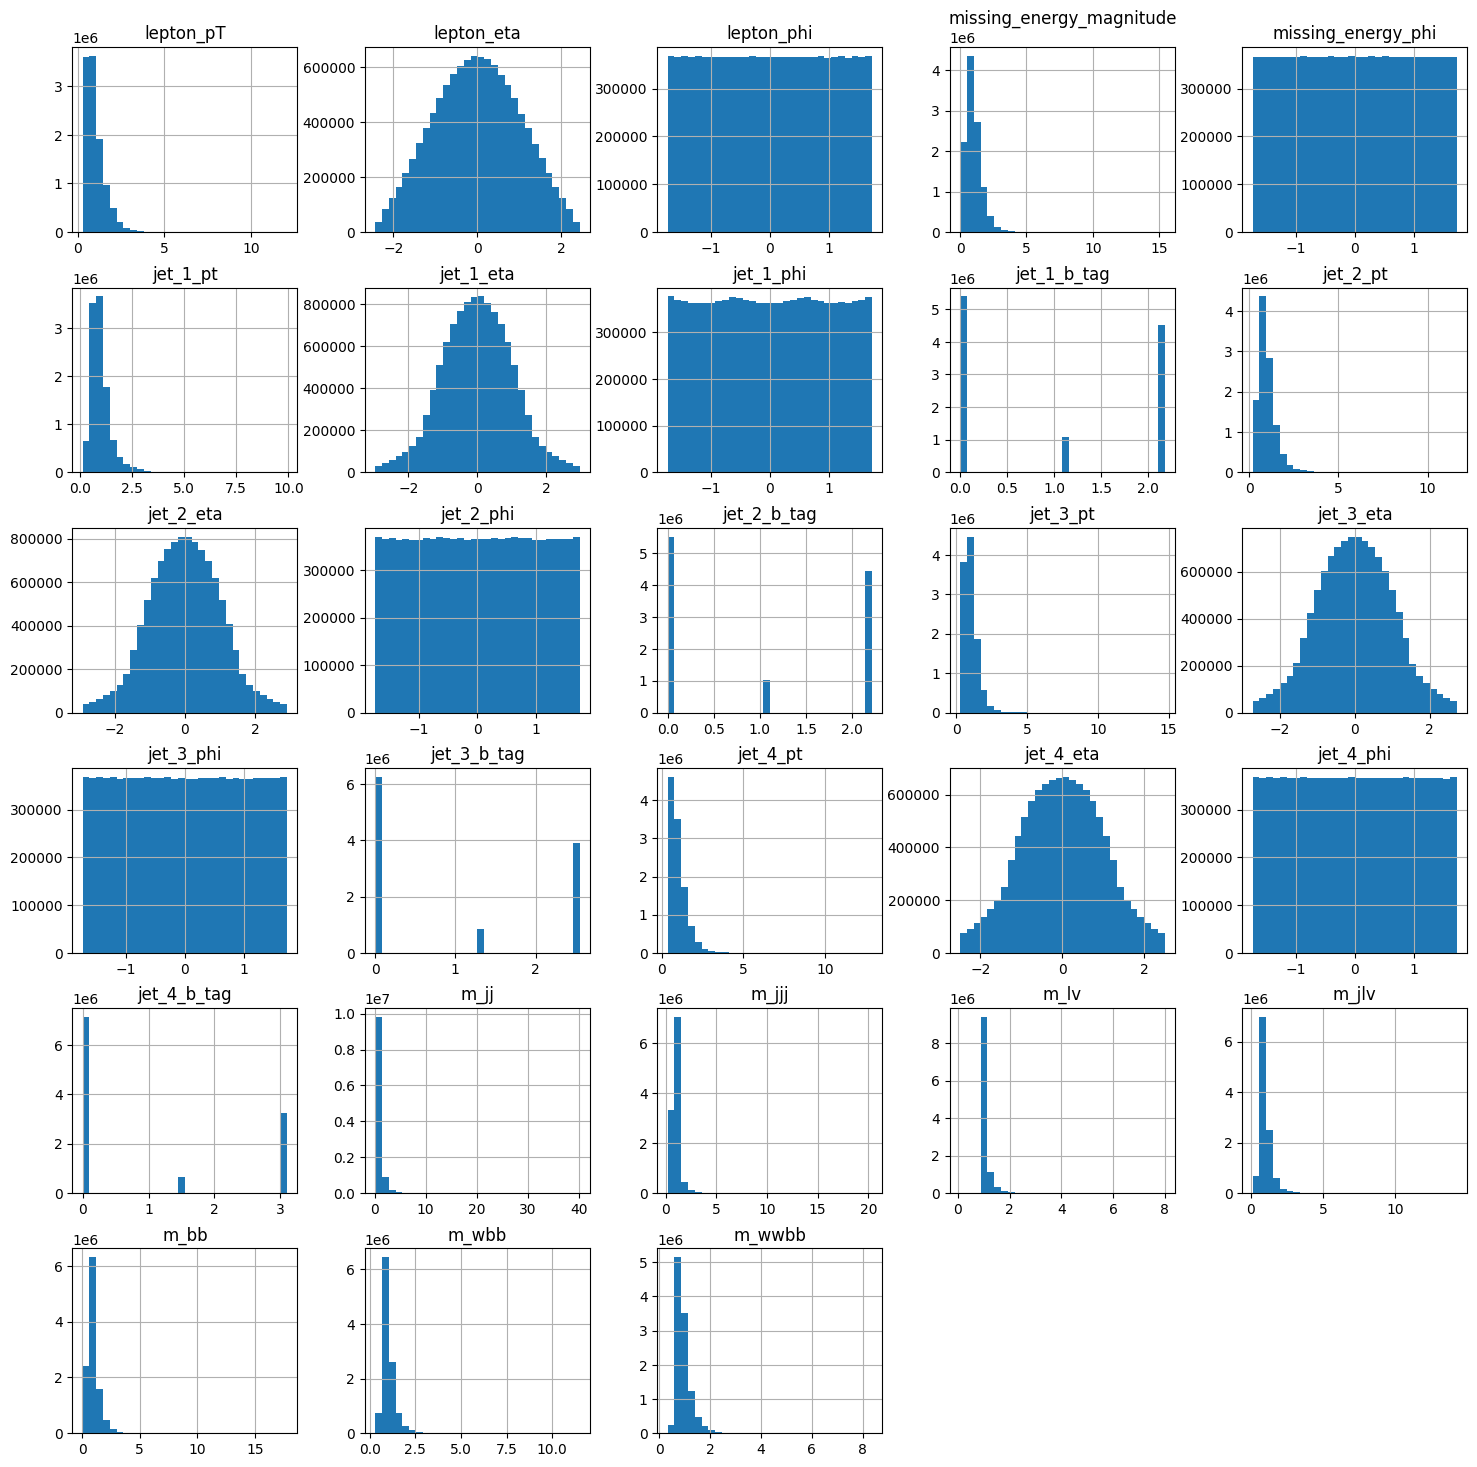

In [ ]:
df_pandas.iloc[:, 1:].hist(bins=30, figsize=(18,18));

# Class distribution

* The next plot shows the class ditribution between the two classes. There appears to be a slight class imbalance, with 53% of the data representing the signal process and 47% representing the background process.

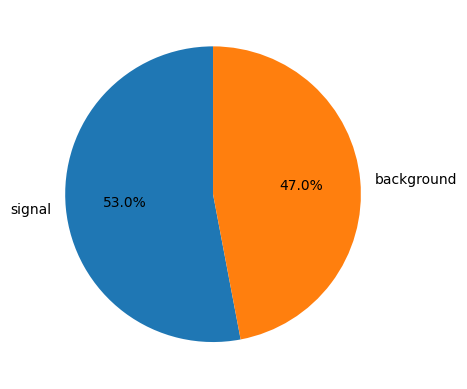

In [ ]:
signal_dist = round((df.query('process == 1.00').shape[0] / df.shape[0])*100, 2)
bckgrnd_dist = 100 - signal_dist
plt.pie([signal_dist, bckgrnd_dist],labels=['signal', 'background'], startangle=90, autopct='%1.1f%%');

# Correlation

* The following graph shows the correlation among all features. The highest correlation exists between the last two features, m_wbb and m_wwbb, with 90%. Another relatively high correlation appears between m_jj and m_jjj, with 80%. All four are high-level features.

A correlation of 90% and 80% is considered high and suggests that the two features are closely related. Apart from these two, the remaining features do not significantly correlate with one another.

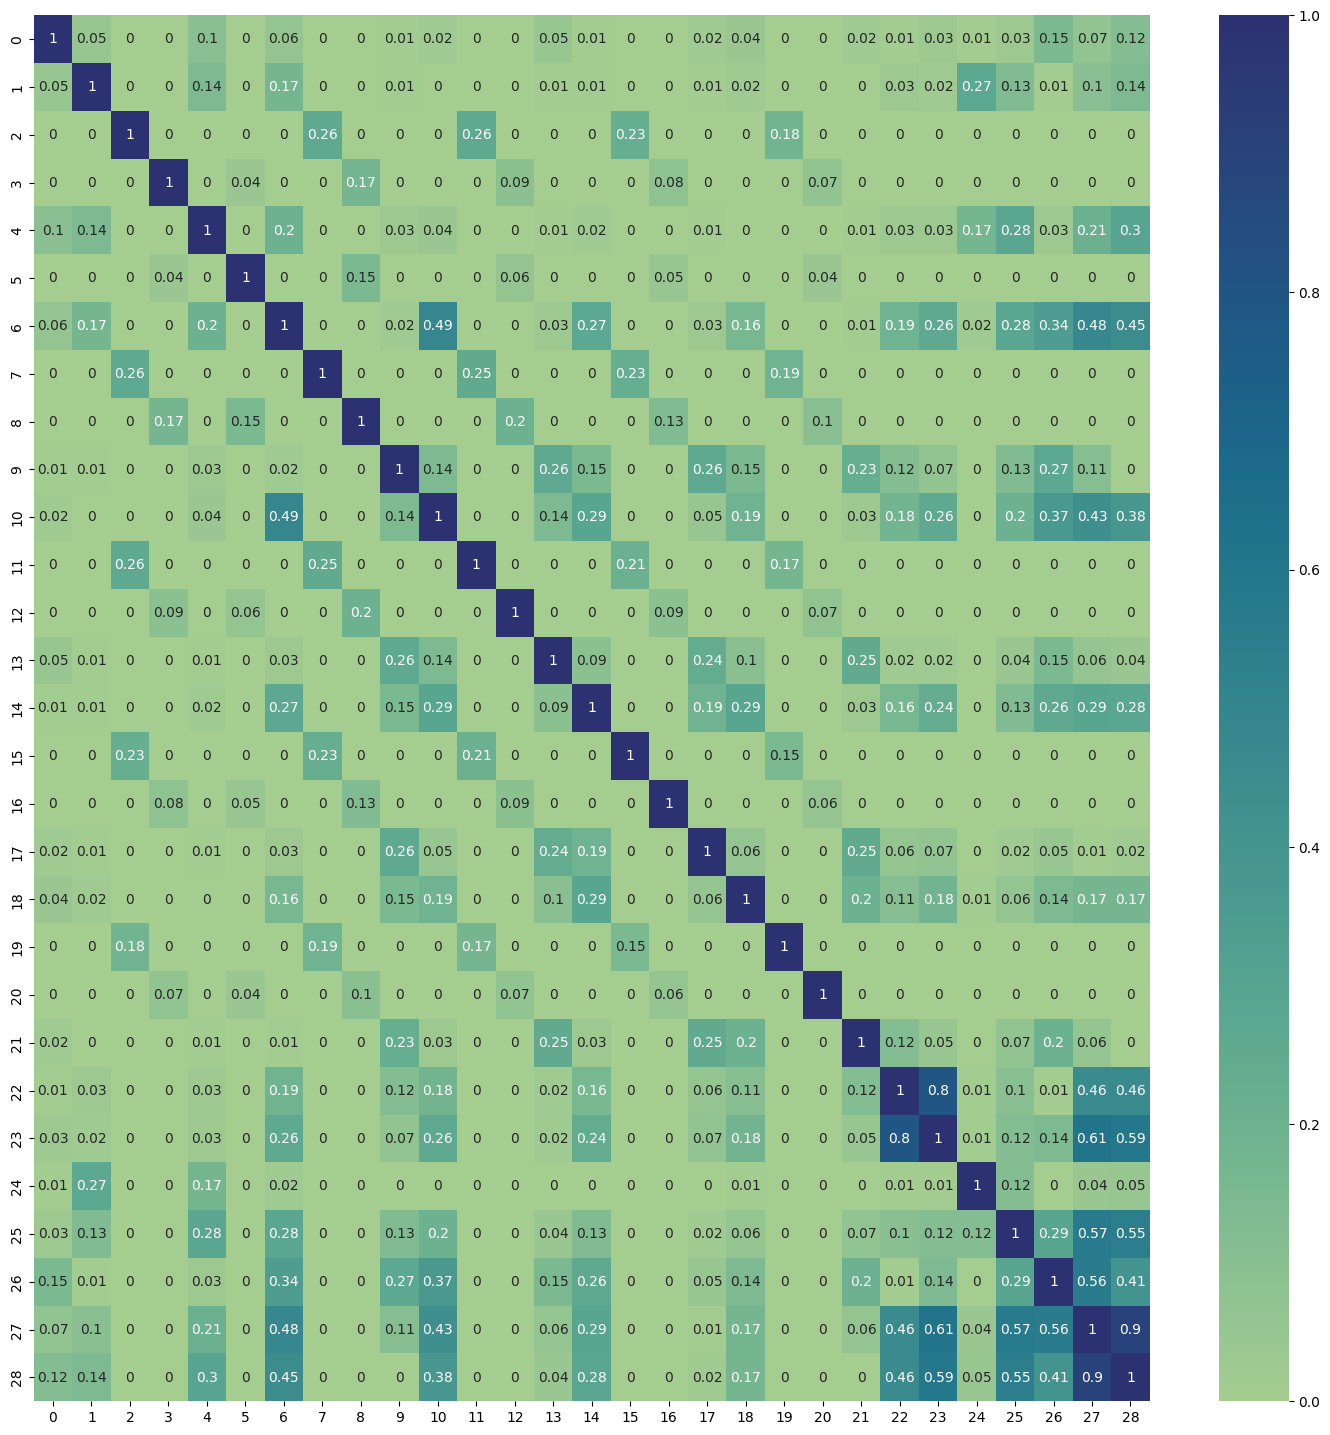

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 18)
pd.options.display.max_rows = 4000

matrix = df.corr().abs().round(2)
sns.heatmap(matrix.to_cupy().get(), annot=True, cmap="crest");

# Outliers

* By analysing the following graph, it is clear that most of the features contain a considerable number of outliers. Outliers can significantly impact the accuracy and reliability of a model. In this dataset, however, outliers comprise a large portion of the instances, making it difficult to entirely eliminate them from the dataset.

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=df_pandas.drop(['process'], axis = 1))
plt.xticks(rotation=45)
fig.set_size_inches(20, 12)
fig.show()

 # 1.2  Data pre-processing
 * Remove correlated feature
Before applying any feature engineering to the data, unnecceary data such as redundant features and outliers must be removed first. The first step is addressing correlated features.

**The next table shows any pair of features with a correlation above 50% is a descending order.**

In [ ]:
corr = matrix.to_pandas().mask(np.tril(np.ones(matrix.shape)).astype(np.bool))
corr = corr[corr >= 0.5].stack().sort_values(kind="quicksort", ascending=False)
corr.reset_index()

,level_0,level_1,0
0,m_wbb,m_wwbb,0.90
1,m_jj,m_jjj,0.80
2,m_jjj,m_wbb,0.61
3,m_jjj,m_wwbb,0.59
4,m_jlv,m_wbb,0.57
5,m_bb,m_wbb,0.56
6,m_jlv,m_wwbb,0.55


* The highest correlation appears between the pairs (m_wbb, m_wwbb) and (m_jj, m_jjj). By looking at the remaining pairs, m_wbb and m_jjj are correlated with other features more than their respective pair.

* Fot this reason, **m_wbb** and **m_jjj** are discarded.

In [ ]:

df_clean = df.drop(['m_wbb', 'm_jjj'], axis=1)
columns = [x for x in columns if x != 'm_wbb' and x != 'm_jjj']

 # 1.3 Remove outliers

* To ensure the reliability of the data, it is essential to eliminate data outliers. To achieve this, the first quartile (q1) and third quartile (q3) are first calculated for each feature. Then, the interquartile range (IQR) is measured as the difference between both quartiles. Next, the low and high values are calculated using the following formulas:

* low = q1 - 1.5*IQR  
* high = q3 + 1.5*IQR

In [ ]:
def remove_outliers__col(df_in, col_name, df_out, iqr_range=1.5):
    [q1, q3] = cp.quantile(cp.asarray(df_in[col_name]), [0.25, 0.75])
    iqr = q3 - q1
    low  = q1 - (iqr_range * iqr)
    high = q3 + (iqr_range * iqr)
    df_out = df_out.query('' + col_name + ' > ' +  str(low)).query('' + col_name + ' < ' +  str(high))
    return df_out

def remove_outliers(_df, iqr_range=1.5):
    df_out = _df.copy(deep=True)
    for x in _df:
        if(x != 'process'):
            df_out = remove_outliers__col(_df, x, df_out, iqr_range)

    remaining = (len(df_out)/len(_df)) * 100
    print('The remaining records ammount to {}% of the original data.'.format(round(remaining, 2)))

    return df_out

In [ ]:
df_clean_1 = remove_outliers(df_clean, 1.5)

The remaining records ammount to 53.69% of the original data.


The previous approach in removing the outliers resulted in the elimination of 46.31% of the dataset. This is a huge protion of valuable data, losing this much data will potentially affect the final quality of the trained models.

To overcome this limitation, an updated approach is used that allows eliminating extreme outliers while preserving a larger portion of the data. The formulas for the high and low ranges will be adjusted by increasing the range to 3 interquartile ranges away, resulting in the formulas:

* low = q1 - 3*IQR

* high = q3 + 3*IQR bold text

In [ ]:
df_clean_2 = remove_outliers(df_clean, 3)

The remaining records ammount to 74.26% of the original data.


This approach resulted in the elimination of 25.74% of the data. This new percentage is still significant, but it is much lower than the previous ratio, which eliminated almost half of the dataset. Despite the lost data being valuable, this step was crucial to achieve trustworthy results in the training process.

In [ ]:
df_clean = df_clean_2
df_clean.shape

(8168792, 27)

# 1.4 Data splitting

Before data resampling, normalisation and standardisation, the dataset is splitted into training, validation and test sets. This prevents the risk of data leakage. The first column is used as the label vector (y). The dataset is split into 70%, 10%, 20% for training, validation and testing, respectively.

In [ ]:
df_feat = df_clean.drop('process', axis=1)
df_target = df_clean['process'].astype(int)

In [ ]:
from cuml.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(df_feat, df_target, test_size=0.20, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=101)

 # 1.5 Class distribution
After the removal of outliers, the class imbalance remains in the data with roughly the same ratio.

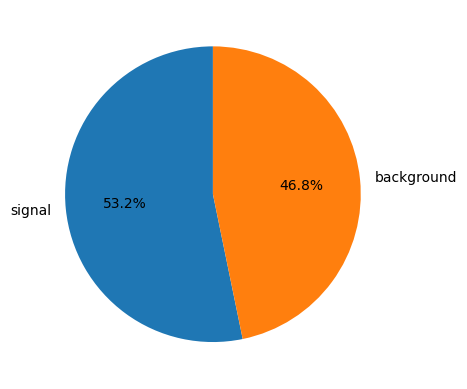

In [ ]:
signal_dist = round((cudf.DataFrame(y_train).query('process == 1.00').shape[0] / y_train.shape[0])*100, 2)
bckgrnd_dist = 100 - signal_dist
plt.pie([signal_dist, bckgrnd_dist],labels=['signal', 'background'], startangle=90, autopct='%1.1f%%');

The SMOTE (Synthetic Minority Over-sampling Technique) algorithm will be used to oversample the background class. SMOTE is a commonly used oversampling method that generates synthetic examples of the underrepresented class by interpolating between existing samples. This effectively increases the number of minority class samples without replicating the existing ones.

For this task, the imbalanced-learn library is used.

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from cuml.neighbors import NearestNeighbors
from cuml.svm import SVC
import time

start = time.time()
nn = NearestNeighbors(n_neighbors=6)
X_resampled, y_resampled = SMOTE(k_neighbors=nn).fit_resample(X_train.to_cupy().get(), y_train.to_cupy().get())
end = time.time()
print('Time passed: {} seconds.'.format(round(end - start, 2)))

Time passed: 431.45 seconds.


In [ ]:
''' convert back to cudf '''
X_train = cudf.DataFrame(X_resampled, columns=columns[1:])
y_train = cudf.DataFrame(y_resampled, columns=['process'])

Due to the huge size of the dataset at hand, the preprocssing stage is computationally expensive and requires a long time to go through. For this reason, going forward, any extracted features or values will be exported to csv files. The exported values can then be loaded for in a later stage without the need to go through the pre-processing stage again. This will allow more freedom for experimentation in the training phase.

In [ ]:
import cudf
import pandas as pd

def export_data_sets(prefix=''):
    if prefix != '':
        prefix += '-'

    print('exporting training set...', end='');
    # Convert to pandas DataFrame before saving to handle large datasets
    X_train.to_pandas().to_csv('./datasets/{}X_train.csv'.format(prefix), index=False)
    y_train.to_pandas().to_csv('./datasets/{}y_train.csv'.format(prefix), index=False)
    print('done!')

    print('exporting validation set...', end='');
    X_val.to_pandas().to_csv('./datasets/{}X_val.csv'.format(prefix), index=False)
    cudf.DataFrame(y_val, columns=['process']).to_pandas().to_csv('./datasets/{}y_val.csv'.format(prefix), index=False)
    print('done!')

    print('exporting test set...', end='');
    X_test.to_pandas().to_csv('./datasets/{}X_test.csv'.format(prefix), index=False)
    cudf.DataFrame(y_test, columns=['process']).to_pandas().to_csv('./datasets/{}y_test.csv'.format(prefix), index=False)
    print('done!')

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('./datasets/', exist_ok=True)

export_data_sets('resampled')

exporting training set...done!
exporting validation set...done!
exporting test set...done!


 # 1.6 Normalisation
In order to ensure the accuracy and reliability of the trained models, it is crucial to normalise the data set. As shown in Figure above , only five features out of 27 remaining follow a perfect normal distribution. Normalisation refers to the procedure of modifying the data such that it has a mean of zero and a standard deviation of one, thereby making it more comprehensible and comparable. The cuML normaliser will be used to normalise the whole dataset.

In [ ]:
# from cuml.preprocessing import Normalizer

# normalizer = Normalizer().fit(X_train)

# X_train = normalizer.transform(X_train)
# X_val = normalizer.transform(X_val)
# X_test = normalizer.transform(X_test)

# 1.7 Standardisation
It is also important to standardise the the data before training. The cuML MaxAbsScaler will be used to normalise the whole dataset.

In [ ]:
# from cuml.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler().fit(X_train)

# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

In [ ]:
''' The two previous operations change the columns naming which later confuses the xgboost model.
    Thus, the columns are renamed to the original names '''
X_train.columns = columns[1:]
X_val.columns = columns[1:]
X_test.columns = columns[1:]

The final version of the three sets are saved to csv format for future use.

In [ ]:
export_data_sets()

exporting training set...done!
exporting validation set...done!
exporting test set...done!


# References
[1] Faster Resampling with Imbalanced-learn and cuML | by Nick Becker | RAPIDS AI | Feb, 2023 | Medium https://medium.com/rapids-ai/faster-resampling-with-imbalanced-learn-and-cuml-6cfc1dae63bf Accessed: 2023-04-16